In [1]:
''' 
Link to Documentation: https://github.com/ultralytics/yolov5

RUN IN TERMINAL BEFORE PROCEEDED IN THE 'fashion-forecast' DIRECTORY:
>   pip install ultralytics
>   git clone https://github.com/ultralytics/yolov5  
>   cd yolov5
>   pip install -r requirements.txt  
>   cd ..
'''

" \nLink to Documentation: https://github.com/ultralytics/yolov5\n\nRUN IN TERMINAL BEFORE PROCEEDED IN THE 'fashion-forecast' DIRECTORY:\n>   pip install ultralytics\n>   git clone https://github.com/ultralytics/yolov5  \n>   cd yolov5\n>   pip install -r requirements.txt  \n>   cd ..\n"

In [15]:
import torch
import numpy as np
import pandas as pd
import os
import math
from PIL import Image

%matplotlib inline 
from matplotlib import pyplot as plt

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True) #force_reload=True

Using cache found in C:\Users\cardon/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-16 Python-3.8.5 torch-2.0.1+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


In [4]:
'''
CODE TO CHANGE DEVICE:
model.cpu()  # CPU
model.cuda()  # GPU
model.to(device)  # i.e. device=torch.device(0)
'''

'\nCODE TO CHANGE DEVICE:\nmodel.cpu()  # CPU\nmodel.cuda()  # GPU\nmodel.to(device)  # i.e. device=torch.device(0)\n'

In [5]:
data = pd.read_csv('filtered_style_stats.csv')
 
# no of csv files with row size
size = 10000
k = math.ceil(len(data.index)/size)
 
for i in range(k):
    df = data[size*i:size*(i+1)]
    df.to_csv(f'./split_csv/style_stats_{i+1}.csv', index=False)


In [16]:
def read_images(img_list, img_names, seasons_only_csv):
    counter = 0
    directory = './yolov5/yolov5/runs/exp4/labels/'
    for img_name in os.listdir(directory):
        if counter == len(seasons_only_csv.index):
            break
        if img_name not in seasons_only_csv.iloc[:, 0].values:
            continue
        if counter%((len(seasons_only_csv.index)/100)*5) == 0:
            print(f"Running... {(counter/len(seasons_only_csv.index))*100:.2f}% finished")
        img_path = os.path.join('./yolov5/yolov5/images/', img_name)
        pil_img = Image.open(img_path)
        np_img = np.array(pil_img)
        #plt.imshow(np_img)             # used to display the images
        #plt.show()
        img_list.append(np_img)
        img_names.append(str(img_path))
        counter += 1
    print(f'Finished with a set of {len(img_list)} images')
    return img_list,img_names 

In [17]:
"""Takes the current results and saves only the information from the maximum 'person' detections
def prioritize_detections_old(detection_df):
    cleaned_df_lst = []
    user_grouped = detection_df.groupby('image')
    for idx, (username, grp) in enumerate(user_grouped):
        person_grp = grp[grp['class name']=='person']
        if (person_grp.size() == 0):
            continue
        if (person_grp.size() == 1):
            row = person_grp.iloc[0].tolist()
            row.append(idx)
            cleaned_df_lst.append(row)
            continue
        # multiple detections -> choose the highest confidence of person
        maxValueIndex = person_grp['confidence'].idxmax()
        row = person_grp.iloc[maxValueIndex].tolist()
        row.append(idx)
        cleaned_df_lst.append(row)

    col_names = list(detection_df[0].columns) + ['df_idx']
    cleaned_df = pd.DataFrame(cleaned_df_lst, columns = col_names)
    return cleaned_df
"""

In [157]:
"""Takes the current results and saves only the information from the maximum 'person' detections"""
def prioritize_detections(detection_df):
    max_confidence = detection_df.groupby(['image'])['confidence'].transform('max')
    #print(max_confidence)
    cleaned_df = detection_df.loc[detection_df['confidence'] == max_confidence]
    #print(cleaned_df)
    return cleaned_df

In [163]:
# Used to crop image in a 1:1 aspect ratio no smaller than 256 pixels centered around the person detection
def crop_image(img, xmin, ymin, xmax, ymax): 
    w, h = (ymax-ymin), (xmax-xmin)
    max_dim = max(w, h)
    
    img = img[xmin:xmax, ymin:ymax]
    img_square = np.ones([max_dim,max_dim], dtype=np.uint8)*0 # chose gray for the least data insight
    background = Image.fromarray(img_square)
    pil_img = Image.fromarray(img)

    background.paste(pil_img, (ymin,xmin))
    return background

In [176]:
"""Takes the cleaned df data and crops each image to it's detected bounding box dimensions"""
def crop_detections(cleaned_df, TOTAL_IMG):
    directory = './yolov5/yolov5/images/'
    save_dir = './yolov5/yolov5/crop-images/'
    df_idx = 0
    for idx, img_name in enumerate(os.listdir(directory)):
        if idx == TOTAL_IMG:
            break
        print("df_idx first:", df_idx)
        print(img_name[:-4], cleaned_df['image'].values[df_idx])
        if img_name[:-4] not in cleaned_df['image'].values:
            continue
        print("df_idx first:", df_idx)
        xmin, ymin, xmax, ymax = cleaned_df.loc[df_idx][['xmin', 'ymin', 'xmax', 'ymax']]

        img_path = os.path.join(directory, img_name)
        pil_img = Image.open(img_path).convert("L")
        np_img = np.array(pil_img)
        crop_img = crop_image(np_img, int(xmin), int(ymin), int(xmax), int(ymax))
        crop_img.show()

        save_path = os.path.join(save_dir, img_name)
        print(save_path)
        crop_img.save(save_path)
        df_idx += 1
    return df_idx


---------------------------------------
Beginning run

Uploading model results to a pandas dataframe
Results saved with length 345883

Removing all inaccurate and low confidence detections
Left with a dataset of 276648 images

Performing final image crop
000ecstaSY000-75818 000ecstaSY000-75818


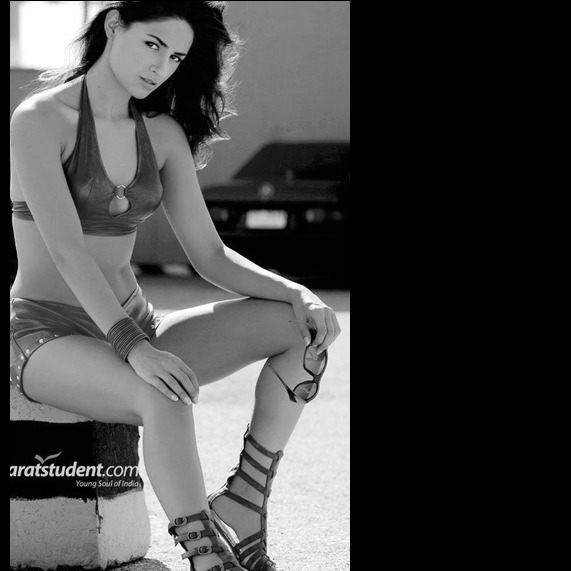

./yolov5/yolov5/crop-images/000ecstaSY000-75818.jpg
000ecstaSY000-75819 000ecstaSY000-75819


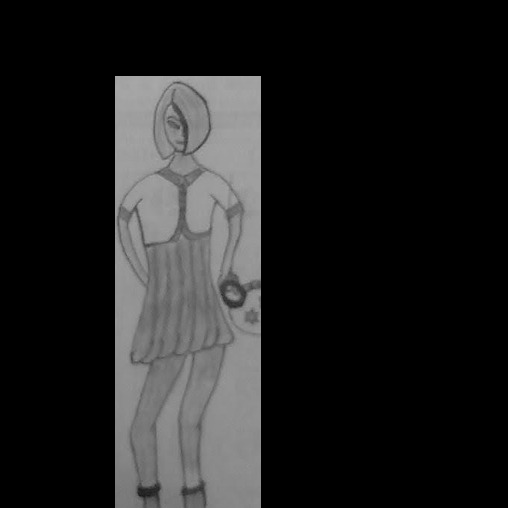

./yolov5/yolov5/crop-images/000ecstaSY000-75819.jpg
000ecstaSY000-75820 0011zm-129448
0011zm-129448 0011zm-129448


KeyError: 2

In [177]:
directory = './split_csv/'
'''for filename in os.listdir(directory):
    print(f"---------------------------------------\nBeginning {filename} batch\n")
    
    filepath = os.path.join(directory, filename)
    df = pd.read_csv(filepath)
    img_list = []
    img_names = []
    img_list, img_names = read_images(img_list, img_names, df)

    print(f"\nRunning the model")
    results = model(img_list)  # inference
    results.save() # cropped detections dictionary
    #results.show()
'''
print(f"---------------------------------------\nBeginning run\n")
print(f"Uploading model results to a pandas dataframe")
detection_df = pd.read_csv("yolov5_labels.csv", header=0)
print(f"Results saved with length {len(detection_df)}\n")
'''
for idx, df in enumerate(detection_df):
    person_df = df[df['name']=='person']
    print(person_df.index)
'''

print(f"Removing all inaccurate and low confidence detections")
cleaned_df = prioritize_detections(detection_df)
TOTAL_IMG = len(cleaned_df.index)
print(f"Left with a dataset of {TOTAL_IMG} images\n")

print(f"Performing final image crop")
num_saved = crop_detections(cleaned_df, TOTAL_IMG)
print(f"Cropping complete.\n{num_saved} saved to \'./yolov5/yolov5/crop-data/\'")
print("Execution complete for full dataset :D")

    